# การพลอตข้อมูลไอน้ำในอากาศจากภาพดาวเทียม GOES13 แบนด์ Water Vapor

โค้ดได้มาจาก MetPy Monday ลิงก์นี้ https://www.youtube.com/watch?v=1tMN_Ucbvqk&list=PLQut5OXpV-0ir4IdllSt1iEZKTwFBa7kO&index=43

## นำเข้าไลบราลี่

In [11]:
# นำเข้าไลบราลี่
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
import numpy as np

In [12]:
file_wv = 'goes13.2011.117.200229.BAND_03.nc' # แบนด์ 3 water vapor

In [13]:
# เปิดข้อมูลไอน้ำมาเก็บไว้
ds_wv = Dataset(file_wv, 'r')

In [14]:
# แปลงข้อมูล 16 บิท เป็น 10 บิท
wv_10bit = ds_wv.variables['data'][0]/32

In [15]:
# mask ค่าพิกัดสูงของ water vapor
lat_wv = np.ma.masked_values(ds_wv.variables['lat'][:], 2.14329e+09) # 2.14329e+09 เป็นค่าพิกัดสูงสุดที่เกินจริงที่ต้อง mask ไว้ว่าจะไม่เอาใช้ 
lon_wv = np.ma.masked_values(ds_wv.variables['lon'][:], 2.14329e+09)

In [16]:
# apply masked 
wv_masked = np.ma.masked_array(wv_10bit, mask=lat_wv.mask)

## แปลงค่า Raw count เป็นค่า Water vapor ใช้หลักการเดียวกันกับอินฟราเรดในการหา Brightness Temperature

In [17]:
# ค่า m และ b จากตาราง 1-2  ใช้ channel 3 จากลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#scene
m_wv = 38.8383
b_wv =29.1287

#คำนวนค่า R นั่นคือค่า Radiance
R_wv = (wv_masked - b_wv)/m_wv

In [18]:
#กำหนดค่า inverse pluck function constants
c1 = 1.191066e-5
c2 = 1.438833

In [20]:
# ใช้ค่าจากตาราง 2-6 GOES-13 สำหรับแบนด์ 3 เพื่อใช้ค่า v กับ alfa และ beta จากลิงก์ https://www.ospo.noaa.gov/Operations/GOES/calibration/gvar-conversion.html#scene
v_wv = 1521.66

u_wv = -3.607841 #alfa

bt_wv = 1.010010 #beta

In [21]:
# คำนวนค่า Teff 
T_eff_wv = (c2*v_wv)/(np.log(1+(c1*v_wv**3)/R_wv)) # invalid value encountered in log เกิดจาก missing value ไม่มีปัญหา

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [22]:
# คำนวณหาค่าไอน้ำจากแบนด์ 3
BT_wv = u_wv + bt_wv * T_eff_wv
BT_wv.max() #ตรวจสอบค่าไอน้ำ

260.76617

## พลอตแผนที่ไอน้ำในอากาศ GOES13 แบนด์ 3

In [23]:
## พลอตแผนที่ไอน้ำในอากาศ GOES13 แบนด์ 3
import numpy as np
# พลอตแผนที่ค่าไอน้ำในอากาศ
vtime = num2date(ds_wv.variables['time'][:], units=ds_wv.variables['time'].units) #เซตค่าตัวแปรเวลา

mapcrs = ccrs.Geostationary(central_longitude=-75)

# หาค่า max min index ที่อยู่ในรูปของพิกัดภูมิศาสตร์ แล้วจะทำการแปลงไปเป็นระบบพิกัด Geostationary
ilon_min = np.unravel_index(np.argmin(lon_wv), lon_wv.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilon_max = np.unravel_index(np.argmax(lon_wv), lon_wv.shape) #หาอินเด็กซ์ของลองจิจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

ilat_min = np.unravel_index(np.argmin(lat_wv), lat_wv.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D
ilat_max = np.unravel_index(np.argmax(lat_wv), lat_wv.shape) #หาอินเด็กซ์ของละติจูดที่ต่ำสุด แล้วทำให้ shape ของอาเรย์เท่าเดิมคือ 2D

#แปลงไปเป็นระบบพิกัด Geostationary
LONpt0 = mapcrs.transform_point(lon_wv[ilon_min],lat_wv[ilon_min], ccrs.Geodetic() )[0]
LONpt1 = mapcrs.transform_point(lon_wv[ilon_max],lat_wv[ilon_max], ccrs.Geodetic() )[0]

LATpt0 = mapcrs.transform_point(lon_wv[ilat_min],lat_wv[ilat_min], ccrs.Geodetic() )[1]
LATpt1 = mapcrs.transform_point(lon_wv[ilat_max],lat_wv[ilat_max], ccrs.Geodetic() )[1]

C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
C:\Users\Admin\anaconda3\envs\metpy\lib\site-packages\cartopy\cr

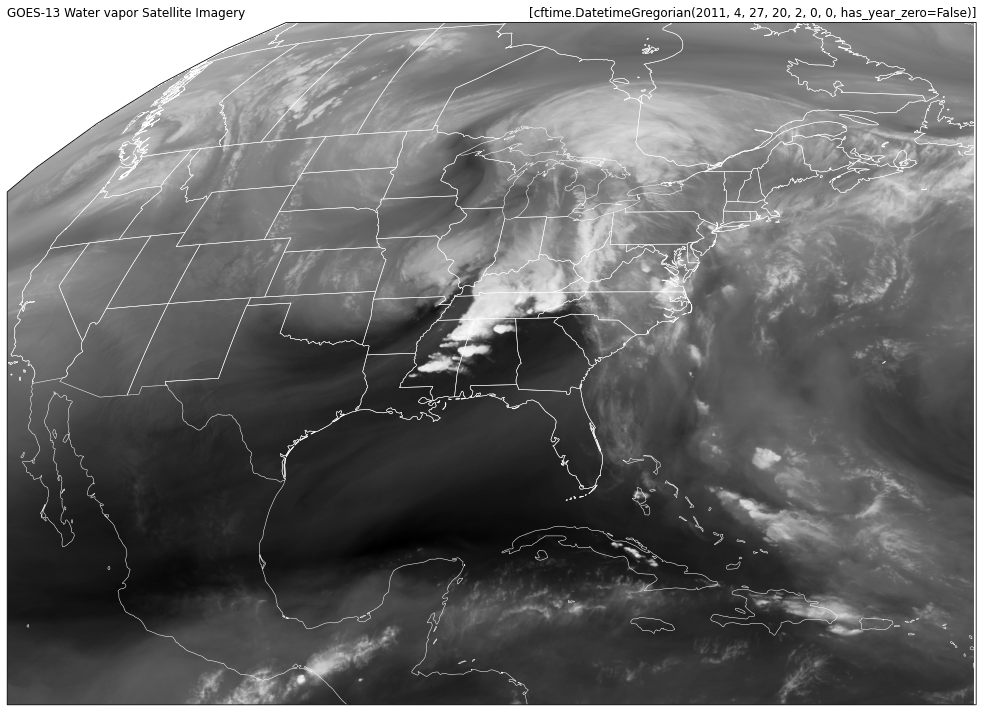

In [24]:
fig = plt.figure(1, figsize=(19,10))
ax = plt.subplot(111, projection=mapcrs)

img = ax.imshow(BT_wv, cmap='Greys', origin='upper',   #BT_wv และเปลี่ยนเป็น Greys
                extent=(LONpt0, LONpt1, LATpt0, LATpt1)) 

ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='white', linewidth = 0.5)
ax.add_feature(cfeature.STATES.with_scale('50m'), edgecolor='white', linewidth = 0.5)

plt.title(vtime, loc='right')
plt.title('GOES-13 Water vapor Satellite Imagery', loc='left')

plt.tight_layout()
plt.show()

* สีขาวที่สว่าง แสดงถึงเมฆที่มีปริมาณไอน้ำอยู่มาก ในขณะที่บริเวณที่มีสีดำเช่น ในแผ่นดินเม็กซิโกและในอ่าวเม็กซิโก ค่อนข้างที่จะมีไอน้ำในอากาศที่น้อยกว่าเมื่อเทียบกับนอกชายฝั่งแอตแลนติค
* อ่านการแปลผลเพิ่มเติมจากลิงก์นี้ https://cimss.ssec.wisc.edu/satellite-blog/archives/3
* อย่างไรก็ตาม หากมีการปรับให้แสดงแผนที่ไอน้ำในอากาศแบบสี จะทำให้ช่วยในการแปลผลไอน้ำในแต่ละระดับชั้นบรรยากาศได้ดีขึ้น

### งานมอบหมายนิสิต
* ให้นิสิตดาวน์โหลดข้อมูลวันที่ 26 และ 28 สิงหาคม 2011 ของข้อมูล GOES13 ซึ่งเป็นช่วงที่พายุเฮอริเคน Irene พัดเข้ามาในพื้นที่ทางตะวันออกของประเทศสหรัฐอเมริกา อ่านจากลิงก์นี้ https://en.wikipedia.org/wiki/Hurricane_Irene
* ให้นิสิตทำการพลอตข้อมูลไอน้ำในอากาศ โดยใช้โค้ดด้านบน
* ให้นิสิตบรรยายผลที่ได้จากภาพดาวเที่ยม โดยเปรียบเทียบระหว่างข้อมูลสองวันดังกล่าว 